<a href="https://colab.research.google.com/github/pinilDissanayaka/Crop-Recommendation-System/blob/main/Crop_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download atharvaingle/crop-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
License(s): apache-2.0
  0% 0.00/63.7k [00:00<?, ?B/s]
100% 63.7k/63.7k [00:00<00:00, 28.3MB/s]


In [4]:
! unzip /content/crop-recommendation-dataset.zip

Archive:  /content/crop-recommendation-dataset.zip
  inflating: Crop_recommendation.csv  


In [6]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

In [34]:
df = pd.read_csv('/content/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [35]:
class_names=pd.Categorical(df['label']).categories

In [36]:
df['label'] = pd.Categorical(df['label']).codes
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


In [9]:
X = df.drop(['label'],axis=1).values
y = df['label'].values

print(X.shape, y.shape)

(2200, 7) (2200,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_raw, y_train, y_raw = train_test_split(X, y, test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_raw, y_raw, test_size=0.3)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Val', X_val.shape, y_val.shape)

Train (1320, 7) (1320,)
Test (616, 7) (616,)
Val (264, 7) (264,)


In [11]:
import keras

inputs = keras.Input((7,))

x = keras.layers.Reshape((7, 1))(inputs)
x = keras.layers.LSTM(48)(x)
x = keras.layers.Dense(24, activation="gelu")(x)
outputs = keras.layers.Dense(22, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 48)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │             550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,326 (44.24 KB)

 Trainable params: 11,326 (44.24 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='crop_recommendation_lstm.best.keras',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

In [13]:
EPOCHS=100

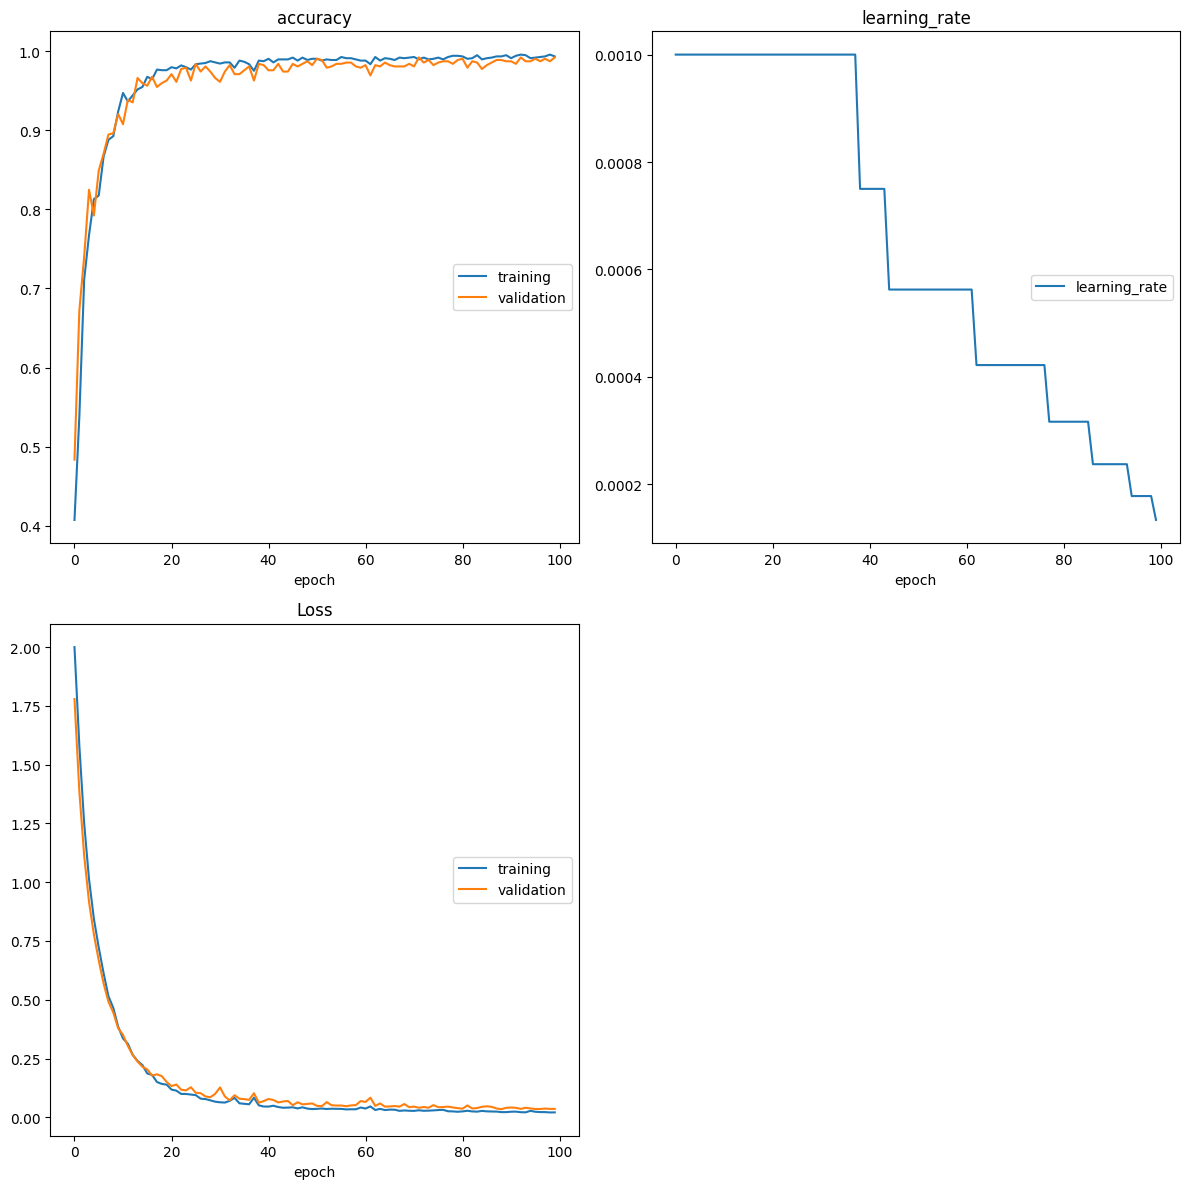

accuracy
	training         	 (min:    0.408, max:    0.995, cur:    0.993)
	validation       	 (min:    0.484, max:    0.992, cur:    0.992)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.021, max:    2.000, cur:    0.021)
	validation       	 (min:    0.035, max:    1.779, cur:    0.036)
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9940 - loss: 0.0197 - val_accuracy: 0.9919 - val_loss: 0.0357 - learning_rate: 1.3348e-04
Restoring model weights from the end of the best epoch: 89.


In [15]:
model_history=model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test),
          callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

In [40]:
model.load_weights('/content/crop_recommendation_lstm.best.keras')

In [41]:
y_pred = keras.ops.argmax(model.predict(X_val), 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [42]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.24%


In [43]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        16
           8       0.92      0.92      0.92        12
           9       1.00      1.00      1.00        12
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        14
          17       1.00    

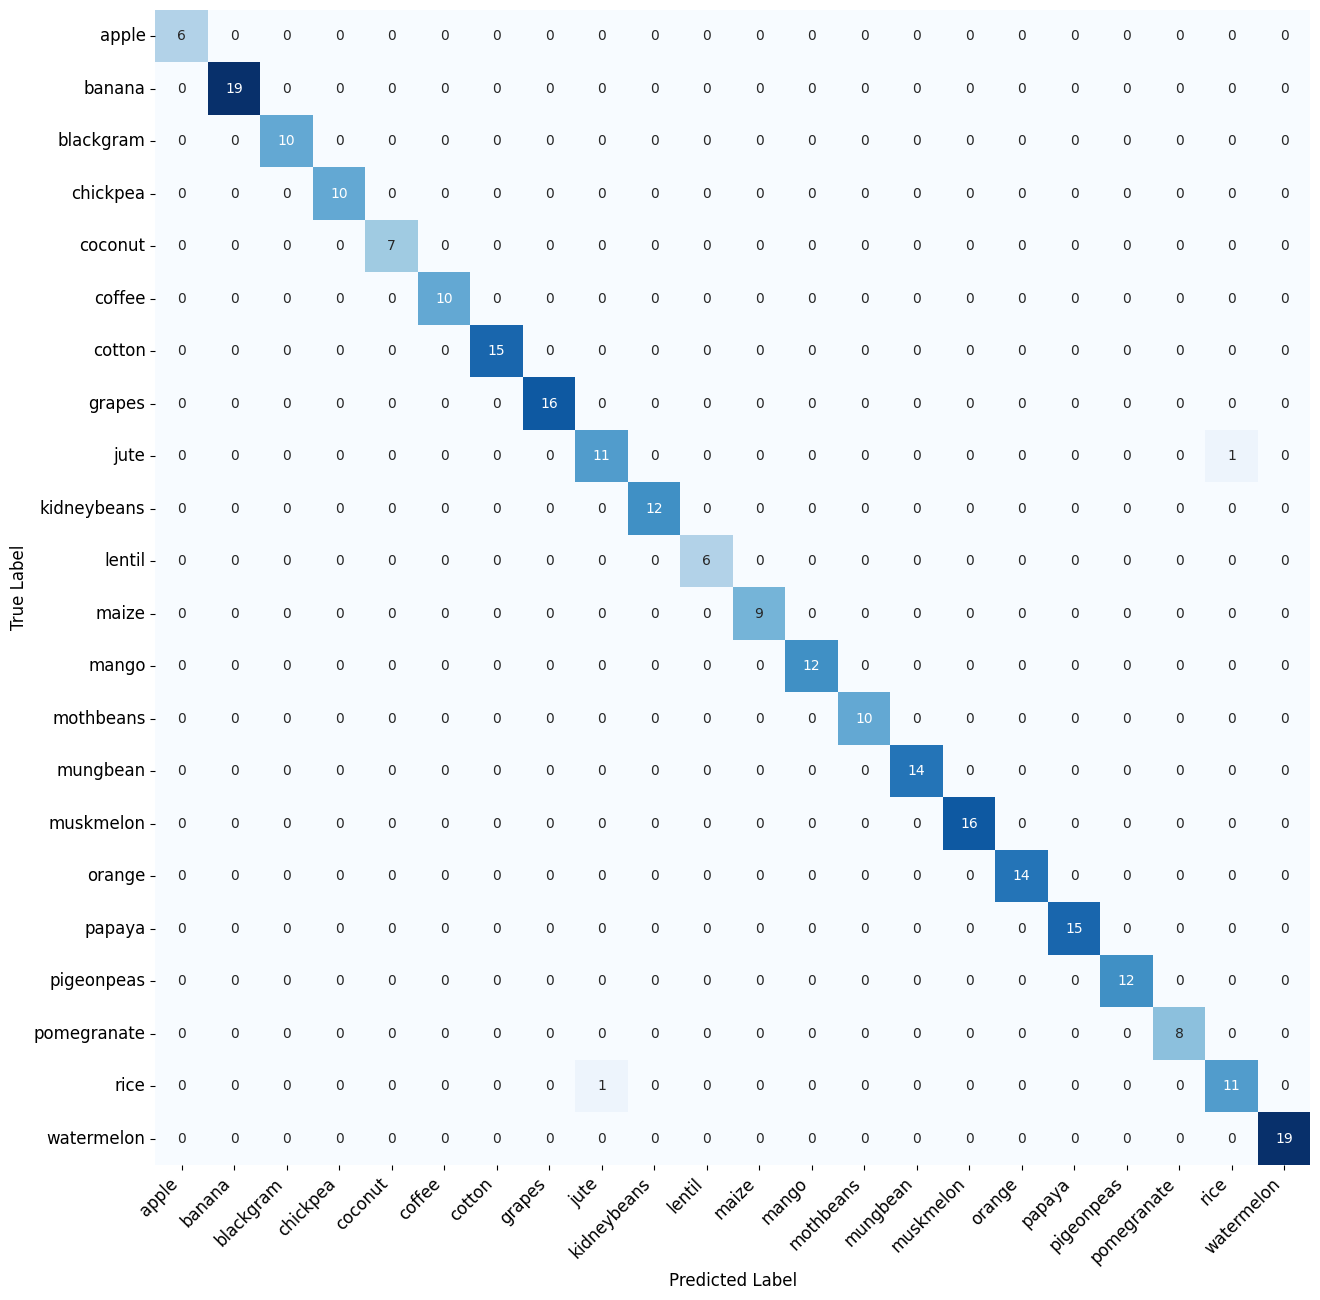

[[ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

plot_heatmap(y_val, y_pred, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(y_val, y_pred)
print(cm)


In [45]:
from tensorflow.keras.models import save_model

save_model(model, "cro_recommendation.keras")

In [47]:
import pickle


import pickle

with open('croprecommendation_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)